# Benchmarking of clustering methods 

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

Update: May, 2023

## Hardware

- Sytem: Ubuntu 18.04.5 LTS
- CPU: Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz (12 cores)
- Disk: SAMSUNG MZ7LH960HAJR-00005 (SSD)
- RAM: 64G(32Gx2) DDR4 2666MHz
- GPU: RTX2080Ti (Driver Version: 495.29.05, CUDA Version: 11.5)

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27
- openTSNE==0.6.1

## 0. Configure the environment

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import tracemalloc  # monitor memory usage
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import scipy.stats

# We use UMAP here
import umap  # this is CPU-based UMAP, use cuML for GPU version

# tested methods
import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch

from umap.umap_ import nearest_neighbors
from scipy.sparse import issparse, coo_matrix, csr_matrix

# louvain
import louvain
# leiden
import leidenalg
import igraph as ig

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

# load table, used column=motif_F10
df = pd.read_csv("./Fly_dev_table.motif.F10.csv", index_col=[0,1,2], header=[0,1])
# Prior knowledge: NSUN6-like TCNA, else, NSUN2-like
df[("INFO", "Priori")] = "Type I"
df.loc[df[("INFO", "motif")].isin(["TCCA", "TCTA", "TCGA", "TCAA"]), ("INFO", "Priori")] = "Type II"

enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row[("INFO", "motif_F10")].upper()]
    return enc.transform(seq).toarray().reshape(-1)

onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)


## 1. Generate UMAP

In [2]:
def UMAP(onehot_input, df):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=0.01, n_jobs=4, n_neighbors=20, verbose=True)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

_, _, df_UMAP = UMAP(onehot_input, df)

UMAP
UMAP(init='random', min_dist=0.01, n_jobs=4, n_neighbors=20, random_state=42, verbose=True)
Fri Apr  1 22:08:14 2022 Construct fuzzy simplicial set
Fri Apr  1 22:08:14 2022 Finding Nearest Neighbors
Fri Apr  1 22:08:14 2022 Building RP forest with 10 trees
Fri Apr  1 22:08:15 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Fri Apr  1 22:10:46 2022 Finished Nearest Neighbor Search
Fri Apr  1 22:10:48 2022 Construct embedding



Fri Apr  1 22:11:11 2022 Finished embedding
UMAP time: 176.07669878005981 sec
UMAP RAM: 0.0 MB



**We also generate nearest neighbor graph with UMAP for Louvain and Leiden**

Functions were obtained from the source code of `Scanpy`.

In [3]:
def get_sparse_matrix_from_indices_distances_umap(
        knn_indices, knn_dists, n_obs, n_neighbors
    ):
    from scipy.sparse import issparse, coo_matrix, csr_matrix
    rows = np.zeros((n_obs * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_obs * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_obs * n_neighbors), dtype=np.float64)

    for i in range(knn_indices.shape[0]):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            else:
                val = knn_dists[i, j]

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    result = coo_matrix((vals, (rows, cols)), shape=(n_obs, n_obs))
    result.eliminate_zeros()
    return result.tocsr()

def compute_connectivities_umap(
        knn_indices,
        knn_dists,
        n_obs,
        n_neighbors,
        set_op_mix_ratio=1.0,
        local_connectivity=1.0,
    ):
    from scipy.sparse import issparse, coo_matrix, csr_matrix
    from umap.umap_ import fuzzy_simplicial_set
    X = coo_matrix(([], ([], [])), shape=(n_obs, 1))
    connectivities = fuzzy_simplicial_set(
        X,
        n_neighbors,
        None,
        None,
        knn_indices=knn_indices,
        knn_dists=knn_dists,
        set_op_mix_ratio=set_op_mix_ratio,
        local_connectivity=local_connectivity,
    )

    if isinstance(connectivities, tuple):
        # In umap-learn 0.4, this returns (result, sigmas, rhos)
        connectivities = connectivities[0]

    distances = get_sparse_matrix_from_indices_distances_umap(
        knn_indices, knn_dists, n_obs, n_neighbors
    )

    return distances, connectivities.tocsr()

def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix."""
    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except KeyError:
        pass
    return g

def get_igraph(onehot_input, random_state = 42, metric="euclidean", n_neighbors = 20, metric_kwds={}, angular=False, verbose=False):
    time0 = time.time()
    n_obs = onehot_input.shape[0]
    
    knn_indices, knn_dists, forest = nearest_neighbors(
            onehot_input,
            n_neighbors,
            random_state=random_state,
            metric=metric,
            metric_kwds=metric_kwds,
            angular=angular,
            verbose=verbose,
            n_jobs=4,
        )
      
    distances, connectivities = compute_connectivities_umap(knn_indices, knn_dists, n_obs, n_neighbors, set_op_mix_ratio=1.0, local_connectivity=1.0)
 
    g = get_igraph_from_adjacency(connectivities)
    return g, time.time() - time0

In [4]:
g, time_graph = get_igraph(onehot_input)

## 2. Test clustering methods

### 2.1 Partitioning methods 

### K-Means

In [5]:
def cluster_KMeans(df):
    df = df.copy()
    # very fast
    X = np.stack([df["X"], df["Y"]], axis=1)
    print("K-Means:")
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = KMeans(n_clusters=2, random_state=42).fit(X)
    labels = model.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("K-Means time: {} sec".format(time1))
    print("K-Means RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_KMeans(df_UMAP)
t2, m2, _ = cluster_KMeans(df_UMAP)
t3, m3, df_KMeans = cluster_KMeans(df_UMAP)
KMeans_time = [t1, t2, t3]
KMeans_mem  = [m1, m2, m3]


K-Means:
K-Means time: 0.13914036750793457 sec
K-Means RAM: 0.4582939147949219 Mb

K-Means:
K-Means time: 0.13164019584655762 sec
K-Means RAM: 0.4253110885620117 Mb

K-Means:
K-Means time: 0.1259610652923584 sec
K-Means RAM: 0.42490482330322266 Mb



### Gaussian Mixture Model (GMM)

In [6]:
def cluster_GMM(df):
    # very fast
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = GaussianMixture(n_components=2, init_params="random", random_state=42).fit(X)
    model.fit(X)
    labels = model.predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("GMM time: {} sec".format(time1))
    print("GMM RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_GMM(df_UMAP)
t2, m2, _ = cluster_GMM(df_UMAP)
t3, m3, df_GMM = cluster_GMM(df_UMAP)
GMM_time = [t1, t2, t3]
GMM_mem  = [m1, m2, m3]

GMM time: 0.03200554847717285 sec
GMM RAM: 0.722294807434082 Mb

GMM time: 0.03834939002990723 sec
GMM RAM: 0.710331916809082 Mb

GMM time: 0.02554011344909668 sec
GMM RAM: 0.7098617553710938 Mb



### 2.2 Graph-based methods

### Spectral Clustering

In [7]:
def cluster_SpectralClustering(df):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = SpectralClustering(n_clusters=2, gamma=1, n_jobs=4)
    labels = model.fit_predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("SpectralClustering time: {} sec".format(time1))
    print("SpectralClustering RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_SpectralClustering(df_UMAP)
t2, m2, _ = cluster_SpectralClustering(df_UMAP)
t3, m3, df_SpectralClustering = cluster_SpectralClustering(df_UMAP)
SpectralClustering_time = [t1, t2, t3]
SpectralClustering_mem  = [m1, m2, m3]

SpectralClustering time: 8.103001117706299 sec
SpectralClustering RAM: 2155.00324344635 Mb

SpectralClustering time: 8.275740385055542 sec
SpectralClustering RAM: 2154.6371850967407 Mb

SpectralClustering time: 8.42909049987793 sec
SpectralClustering RAM: 2154.6371850967407 Mb



## Louvain

In [8]:
def cluster_Louvain(df, graph):
    df = df.copy()
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    partition_type = louvain.RBConfigurationVertexPartition
    model = louvain.find_partition(graph, partition_type, seed=42, resolution_parameter=0.35)
    labels = np.array(model.membership)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("Louvain time: {} sec".format(time1))
    print("Louvain RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    
    df["Cluster"] = labels
    return time1, mem, df

t1, m1, _ = cluster_Louvain(df_UMAP, g)
t2, m2, _ = cluster_Louvain(df_UMAP, g)
t3, m3, df_Louvain = cluster_Louvain(df_UMAP, g)
Louvain_time = [t1, t2, t3]
Louvain_mem  = [m1, m2, m3]

Louvain time: 0.38994860649108887 sec
Louvain RAM: 0.35763072967529297 Mb

Louvain time: 0.3537142276763916 sec
Louvain RAM: 0.3540534973144531 Mb

Louvain time: 0.3351781368255615 sec
Louvain RAM: 0.3540534973144531 Mb



## Leiden

In [9]:
def cluster_Leiden(df, graph):
    df = df.copy()
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    partition_type = leidenalg.RBConfigurationVertexPartition
    model = leidenalg.find_partition(graph, partition_type, seed=42, resolution_parameter=0.35)
    labels = model.membership
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("Louvain time: {} sec".format(time1))
    print("Louvain RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    
    df["Cluster"] = labels
    return time1, mem, df

t1, m1, _ = cluster_Leiden(df_UMAP, g)
t2, m2, _ = cluster_Leiden(df_UMAP, g)
t3, m3, df_Leiden = cluster_Leiden(df_UMAP, g)
Leiden_time = [t1, t2, t3]
Leiden_mem  = [m1, m2, m3]

Louvain time: 0.19641399383544922 sec
Louvain RAM: 0.3566017150878906 Mb

Louvain time: 0.19185185432434082 sec
Louvain RAM: 0.3540534973144531 Mb

Louvain time: 0.1935873031616211 sec
Louvain RAM: 0.3540534973144531 Mb



### 2.3 Hierarchical methods

### Agglomerative Clustering

In [10]:
def cluster_AgglomerativeClustering(df, linkage="complete"):
    # ~1 sec
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = AgglomerativeClustering(linkage=linkage, n_clusters=2)
    labels = model.fit_predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("AgglomerativeClustering time: {} sec".format(time1))
    print("AgglomerativeClustering RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_AgglomerativeClustering(df_UMAP)
t2, m2, _ = cluster_AgglomerativeClustering(df_UMAP)
t3, m3, df_AgglomerativeClustering = cluster_AgglomerativeClustering(df_UMAP)
AgglomerativeClustering_time = [t1+time_graph, t2+time_graph, t3+time_graph]
AgglomerativeClustering_mem  = [m1, m2, m3]

AgglomerativeClustering time: 1.8006300926208496 sec
AgglomerativeClustering RAM: 302.9227132797241 Mb

AgglomerativeClustering time: 1.7950620651245117 sec
AgglomerativeClustering RAM: 302.92459297180176 Mb

AgglomerativeClustering time: 1.7961456775665283 sec
AgglomerativeClustering RAM: 302.9245948791504 Mb



In [11]:
t1, m1, _ = cluster_AgglomerativeClustering(df_UMAP, linkage="ward")
t2, m2, _ = cluster_AgglomerativeClustering(df_UMAP, linkage="ward")
t3, m3, df_AgglomerativeClustering2 = cluster_AgglomerativeClustering(df_UMAP, linkage="ward")
AgglomerativeClustering_time2 = [t1+time_graph, t2+time_graph, t3+time_graph]
AgglomerativeClustering_mem2  = [m1, m2, m3]

AgglomerativeClustering time: 1.8587019443511963 sec
AgglomerativeClustering RAM: 302.9217414855957 Mb

AgglomerativeClustering time: 1.865170955657959 sec
AgglomerativeClustering RAM: 302.92447090148926 Mb

AgglomerativeClustering time: 1.8610022068023682 sec
AgglomerativeClustering RAM: 302.92447090148926 Mb



### BIRCH

In [12]:
def cluster_BIRCH(df):
    # ~1 sec
    df = df.copy()
    tracemalloc.start()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = Birch(n_clusters=2)
    labels = model.fit_predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("BIRCH  time: {} sec".format(time1))
    print("BIRCH  RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_BIRCH(df_UMAP)
t2, m2, _ = cluster_BIRCH(df_UMAP)
t3, m3, df_BIRCH = cluster_BIRCH(df_UMAP)
BIRCH_time = [t1, t2, t3]
BIRCH_mem  = [m1, m2, m3]

BIRCH  time: 0.33763885498046875 sec
BIRCH  RAM: 1.8286876678466797 Mb

BIRCH  time: 0.33318281173706055 sec
BIRCH  RAM: 1.8135652542114258 Mb

BIRCH  time: 0.332019567489624 sec
BIRCH  RAM: 1.812687873840332 Mb



### 2.4 Density-based methods

### OPTICS

In [13]:
def cluster_OPTICS(df):
    # ~ 12 sec
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = OPTICS(min_cluster_size=100, min_samples=10, xi=0.05,) # , n_jobs=4 
    model.fit(X)
    labels = model.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("OPTICS time: {} sec".format(time1))
    print("OPTICS RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_OPTICS(df_UMAP)
t2, m2, _ = cluster_OPTICS(df_UMAP)
t3, m3, df_OPTICS = cluster_OPTICS(df_UMAP)
OPTICS_time = [t1, t2, t3]
OPTICS_mem  = [m1, m2, m3]

OPTICS time: 9.392059564590454 sec
OPTICS RAM: 3.005115509033203 Mb

OPTICS time: 9.460694074630737 sec
OPTICS RAM: 2.9916820526123047 Mb

OPTICS time: 9.407339334487915 sec
OPTICS RAM: 2.9916820526123047 Mb



### DBSCAN

In [14]:
def cluster_DBSCAN(df):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = DBSCAN(eps=0.4, min_samples=100, n_jobs=4)
    labels = model.fit_predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("DBSCAN time: {} sec".format(time1))
    print("DBSCAN RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    del model
    return time1, mem, df

t1, m1, _ = cluster_DBSCAN(df_UMAP)
t2, m2, _ = cluster_DBSCAN(df_UMAP)
t3, m3, df_DBSCAN = cluster_DBSCAN(df_UMAP)
DBSCAN_time = [t1, t2, t3]
DBSCAN_mem  = [m1, m2, m3]

DBSCAN time: 0.13265442848205566 sec
DBSCAN RAM: 2.017561912536621 Mb

DBSCAN time: 0.12918424606323242 sec
DBSCAN RAM: 2.0090456008911133 Mb

DBSCAN time: 0.1370558738708496 sec
DBSCAN RAM: 2.011715888977051 Mb



### HDBSCAN

In [15]:
def cluster_HDBSCAN(df):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', core_dist_n_jobs=4)
    labels = model.fit(X).labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("HDBSCAN time: {} sec".format(time1))
    print("HDBSCAN RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    del model
    return time1, mem, df

t1, m1, _ = cluster_HDBSCAN(df_UMAP)
t2, m2, _ = cluster_HDBSCAN(df_UMAP)
t3, m3, df_HDBSCAN = cluster_HDBSCAN(df_UMAP)
HDBSCAN_time = [t1, t2, t3]
HDBSCAN_mem  = [m1, m2, m3]

HDBSCAN time: 0.35454678535461426 sec
HDBSCAN RAM: 3.336172103881836 Mb

HDBSCAN time: 0.3411445617675781 sec
HDBSCAN RAM: 3.332674980163574 Mb

HDBSCAN time: 0.337831974029541 sec
HDBSCAN RAM: 3.332674980163574 Mb



### HDBSCAN (soft clustering)

In [16]:
def cluster_HDBSCAN_softclustering(df):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=10, cluster_selection_method='eom', core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    del model
    return time1, mem, df

t1, m1, _ = cluster_HDBSCAN_softclustering(df_UMAP)
t2, m2, _ = cluster_HDBSCAN_softclustering(df_UMAP)
t3, m3, df_HDBSCAN_soft = cluster_HDBSCAN_softclustering(df_UMAP)
HDBSCAN_soft_time = [t1, t2, t3]
HDBSCAN_soft_mem  = [m1, m2, m3]

HDBSCAN soft clustering time: 0.8415451049804688 sec
HDBSCAN soft clustering RAM: 3.332796096801758 Mb

HDBSCAN soft clustering time: 0.8812875747680664 sec
HDBSCAN soft clustering RAM: 3.332674980163574 Mb

HDBSCAN soft clustering time: 0.8541085720062256 sec
HDBSCAN soft clustering RAM: 3.332674980163574 Mb



## 3. Benchmarking

### 3.1 Comparing runtime

                       Method  Time (sec)
0                     K-Means    0.139140
1                     K-Means    0.131640
2                     K-Means    0.125961
3                         GMM    0.032006
4                         GMM    0.038349
5                         GMM    0.025540
6    Agglomerative (complete)    3.994942
7    Agglomerative (complete)    3.989374
8    Agglomerative (complete)    3.990458
9        Agglomerative (ward)    4.053014
10       Agglomerative (ward)    4.059483
11       Agglomerative (ward)    4.055315
12                      BIRCH    0.337639
13                      BIRCH    0.333183
14                      BIRCH    0.332020
15        Spectral Clustering    8.103001
16        Spectral Clustering    8.275740
17        Spectral Clustering    8.429090
18                    Louvain    0.389949
19                    Louvain    0.353714
20                    Louvain    0.335178
21                     Leiden    0.196414
22                     Leiden    0

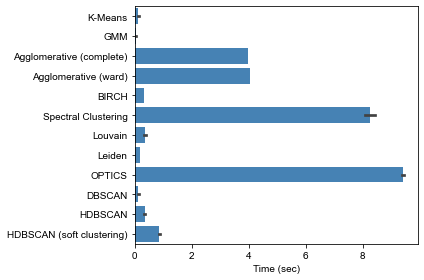

In [17]:
fig, ax = plt.subplots()
df_time = pd.DataFrame([KMeans_time, GMM_time, AgglomerativeClustering_time, AgglomerativeClustering_time2, BIRCH_time, SpectralClustering_time, Louvain_time, Leiden_time, OPTICS_time, DBSCAN_time, HDBSCAN_time, HDBSCAN_soft_time], index=["K-Means", "GMM", "Agglomerative (complete)", "Agglomerative (ward)", "BIRCH", "Spectral Clustering", "Louvain", "Leiden", "OPTICS", "DBSCAN", "HDBSCAN", "HDBSCAN (soft clustering)"]).T
df_time = df_time.melt(var_name="Method", value_name="Time (sec)")

# saving results to disk
df_time.to_csv("Clustering_runtime.csv")

print(df_time)
sns.barplot(data=df_time, y="Method", x="Time (sec)", orient="h", ax=ax, saturation=1, color="steelblue")
ax.set_ylabel("")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("Clustering_runtime.pdf")

### 3.2 Memory Usage

                       Method  Peak Memory (MB)
0                     K-Means          0.458294
1                     K-Means          0.425311
2                     K-Means          0.424905
3                         GMM          0.722295
4                         GMM          0.710332
5                         GMM          0.709862
6    Agglomerative (complete)        302.922713
7    Agglomerative (complete)        302.924593
8    Agglomerative (complete)        302.924595
9        Agglomerative (ward)        302.921741
10       Agglomerative (ward)        302.924471
11       Agglomerative (ward)        302.924471
12                      BIRCH          1.828688
13                      BIRCH          1.813565
14                      BIRCH          1.812688
15        Spectral Clustering       2155.003243
16        Spectral Clustering       2154.637185
17        Spectral Clustering       2154.637185
18                    Louvain          0.357631
19                    Louvain          0

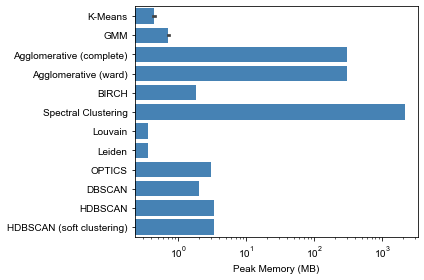

In [18]:
fig, ax = plt.subplots()
df_mem = pd.DataFrame([KMeans_mem, GMM_mem, AgglomerativeClustering_mem, AgglomerativeClustering_mem2, BIRCH_mem, SpectralClustering_mem, Louvain_mem, Leiden_mem, OPTICS_mem, DBSCAN_mem, HDBSCAN_mem, HDBSCAN_soft_mem], index=["K-Means", "GMM", "Agglomerative (complete)", "Agglomerative (ward)", "BIRCH", "Spectral Clustering", "Louvain", "Leiden",  "OPTICS", "DBSCAN", "HDBSCAN", "HDBSCAN (soft clustering)"]).T
df_mem = df_mem.melt(var_name="Method", value_name="Peak Memory (MB)")

# saving results to disk
df_mem.to_csv("Clustering_Memory.csv")

print(df_mem)
sns.barplot(data=df_mem, y="Method", x="Peak Memory (MB)", orient="h", ax=ax, saturation=1, color="steelblue")
ax.set_ylabel("")
ax.set_xscale("log")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("Clustering_Memory.pdf")

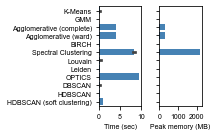

In [50]:
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
fig, axes = plt.subplots(1,2,figsize=(3, 2.),sharey=True)
sns.barplot(data=df_time, y="Method", x="Time (sec)", orient="h", ax=axes[0], saturation=1, color="steelblue")
sns.barplot(data=df_mem, y="Method", x="Peak Memory (MB)", orient="h", ax=axes[1], saturation=1, color="steelblue")
axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[0].set_xlabel("Time (sec)", size=7)
axes[1].set_xlabel("Peak memory (MB)", size=7)
axes[0].set_xticks([0,5,10])
axes[1].set_xticks([0,1000, 2000])
plt.tight_layout()
plt.savefig("Clustering_time_and_mem.h.pdf")

### 3.3 Draw Scatters

In [34]:
def draw_clusters(ax, df, xlabel, ylabel, title, compute_consistency=True):
    clusters = set(df["Cluster"].tolist())
    
    for i in clusters:
        subdf = df[df["Cluster"]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=1, c="lightgray", lw=0)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=1, alpha=1, lw=0, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            # ax.annotate("{}".format(i+1), xy=(c_X, c_Y), color="k", ha="center", va="center", size=6) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel("    ", size=6)
    ax.set_ylabel("    ", size=6)
    ax.set_title(title, size=9)
    df.to_csv("{}.csv".format(title.replace(" ","_")))

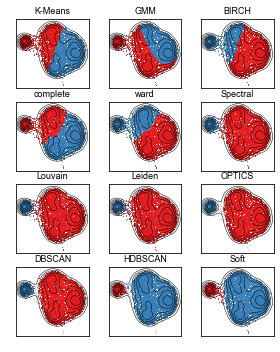

In [38]:
palette = sns.color_palette("Set1")
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette) 

fig, axes = plt.subplots(4,3, figsize=(4,5))

draw_clusters(axes[0][0], df_KMeans, "UMAP-1", "UMAP-2", "K-Means")
draw_clusters(axes[0][1], df_GMM, "UMAP-1", "UMAP-2", "GMM")
draw_clusters(axes[0][2], df_BIRCH, "UMAP-1", "UMAP-2", "BIRCH")

draw_clusters(axes[1][0], df_AgglomerativeClustering, "UMAP-1", "UMAP-2", "complete")
draw_clusters(axes[1][1], df_AgglomerativeClustering2, "UMAP-1", "UMAP-2", "ward")
draw_clusters(axes[1][2], df_SpectralClustering, "UMAP-1", "UMAP-2", "Spectral")

draw_clusters(axes[2][0], df_Louvain, "UMAP-1", "UMAP-2", "Louvain")
draw_clusters(axes[2][1], df_Leiden, "UMAP-1", "UMAP-2", "Leiden")
draw_clusters(axes[2][2], df_OPTICS, "UMAP-1", "UMAP-2", "OPTICS")

draw_clusters(axes[3][0], df_DBSCAN, "UMAP-1", "UMAP-2", "DBSCAN")
draw_clusters(axes[3][1], df_HDBSCAN, "UMAP-1", "UMAP-2", "HDBSCAN")
draw_clusters(axes[3][2], df_HDBSCAN_soft, "UMAP-1", "UMAP-2", "Soft")

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

plt.savefig("Clustering_scatter.4x3.pdf")

### 3.4 Compute consistency 

In [21]:
def cal_Precsion_Recall(df, name, predict_type=[0, 1], expected_type=["Type I", "Type II"]):
    # firstly, get confusion matrix
    exp_values = []
    for i in df[("INFO", "Priori")]:
        if i == expected_type[0]:
            exp_values.append(0)
        else:
            exp_values.append(1)
    pred_values = []
    for i in df["Cluster"]:
        if i == predict_type[0]:
            pred_values.append(0)
        elif i == predict_type[1]:
            pred_values.append(1)
        elif i == -1:
            pred_values.append(-1)
    matrix = metrics.confusion_matrix(exp_values, pred_values)
    if matrix.shape[0] == 3:
        confusion_matrix = pd.DataFrame(matrix, index=[-1, 0, 1], columns=[-1,0,1])
    else:
        confusion_matrix = pd.DataFrame(matrix, index=[0, 1], columns=[0,1])
    
    TP1 = confusion_matrix.loc[0, 0]
    TP2 = confusion_matrix.loc[1, 1]
    
    FP1 = confusion_matrix[0].sum() - TP1
    FP2 = confusion_matrix[1].sum() - TP2
    
    TN1 = confusion_matrix.sum().sum() - confusion_matrix[0].sum() - confusion_matrix.loc[0].sum() + TP1
    TN2 = confusion_matrix.sum().sum() - confusion_matrix[1].sum() - confusion_matrix.loc[1].sum() + TP2
    
    FN1 = confusion_matrix.loc[0].sum() - TP1
    FN2 = confusion_matrix.loc[1].sum() - TP2
    
    Recall_1 = TP1/(TP1+FN1+0.0)
    Precision_1 = TP1/(TP1+FP1+0.0)
    
    Recall_2 = TP2/(TP2+FN2+0.0)
    Precision_2 = TP2/(TP2+FP2+0.0)
    print(name)
    print(confusion_matrix)
    print("===============================")
    return name, Recall_1, Precision_1, Recall_2, Precision_2


In [22]:
Precision_Recall_data = []
Precision_Recall_data.append(cal_Precsion_Recall(df_KMeans, "K-Means", predict_type=[1, 0]))
Precision_Recall_data.append(cal_Precsion_Recall(df_GMM, "GMM", predict_type=[1, 0]))
Precision_Recall_data.append(cal_Precsion_Recall(df_BIRCH, "BIRCH"))

Precision_Recall_data.append(cal_Precsion_Recall(df_AgglomerativeClustering, "Agglomerative (complete)", predict_type=[1, 0]))
Precision_Recall_data.append(cal_Precsion_Recall(df_AgglomerativeClustering2, "Agglomerative (ward)", predict_type=[0, 1]))
Precision_Recall_data.append(cal_Precsion_Recall(df_SpectralClustering, "Spectral Clustering"))

Precision_Recall_data.append(cal_Precsion_Recall(df_Louvain, "Louvain", predict_type=[0, 1]))
Precision_Recall_data.append(cal_Precsion_Recall(df_Leiden, "Leiden", predict_type=[0, 1]))
Precision_Recall_data.append(cal_Precsion_Recall(df_OPTICS, "OPTICS"))

Precision_Recall_data.append(cal_Precsion_Recall(df_DBSCAN, "DBSCAN"))
Precision_Recall_data.append(cal_Precsion_Recall(df_HDBSCAN, "HDBSCAN", predict_type=[1, 0]))
Precision_Recall_data.append(cal_Precsion_Recall(df_HDBSCAN_soft, "HDBSCAN (soft clustering)", predict_type=[1, 0]))

K-Means
      0     1
0  4897  2744
1     1   760
GMM
      0     1
0  3838  3803
1     0   761
BIRCH
      0     1
0  5643  1998
1     1   760
Agglomerative (complete)
      0     1
0  4821  2820
1     1   760
Agglomerative (ward)
      0     1
0  5254  2387
1     1   760
Spectral Clustering
      0    1
0  7523  118
1     3  758
Louvain
      0    1
0  7548   93
1     4  757
Leiden
      0    1
0  7548   93
1     4  757
OPTICS
     -1     0    1
-1    0     0    0
 0  134  7449   58
 1   10     3  748
DBSCAN
    -1     0    1
-1   0     0    0
 0  64  7480   97
 1   1     3  757
HDBSCAN
     -1     0    1
-1    0     0    0
 0  120  7443   78
 1    6     3  752
HDBSCAN (soft clustering)
      0    1
0  7495  146
1     2  759


In [23]:
df_Precision_Recall = pd.DataFrame(Precision_Recall_data, columns=["Method", "Recall (Type I)", "Precision (Type I)", "Recall (Type II)", "Precision (Type II)"])

df_Precision = df_Precision_Recall[["Method", "Precision (Type I)", "Precision (Type II)"]]
df_Precision.columns = ["Method", "Type I", "Type II"]
df_Precision = df_Precision.melt(id_vars=["Method"], var_name="m5C Type")
df_Precision["Metric"] = "Precision"

df_Recall = df_Precision_Recall[["Method", "Recall (Type I)", "Recall (Type II)"]]
df_Recall.columns = ["Method", "Type I", "Type II"]
df_Recall = df_Recall.melt(id_vars=["Method"], var_name="m5C Type")
df_Recall["Metric"] = "Recall"

df_Precision_Recall = pd.concat([df_Precision, df_Recall])
df_Precision_Recall.to_csv("Clustering.metrics.csv")

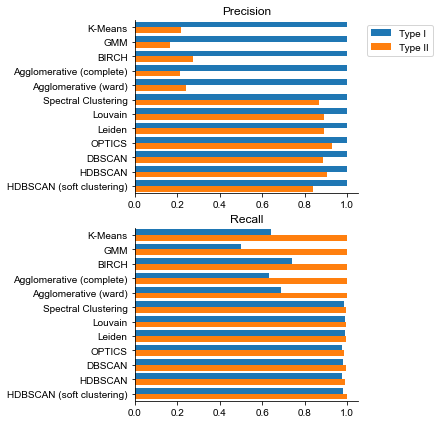

In [24]:
fig, axes = plt.subplots(2,1, figsize=(4,7))
_ = sns.barplot(data=df_Precision, y="Method", x="value", hue="m5C Type", ax=axes[0], saturation=1, orient="h")
axes[0].legend(bbox_to_anchor=(1.02,1))
axes[0].set_title("Precision")
axes[0].set_xlabel("")

_ = sns.barplot(data=df_Recall, y="Method", x="value", hue="m5C Type", ax=axes[1], saturation=1, orient="h")
axes[1].legend_.remove()
axes[1].set_title("Recall")
axes[1].set_xlabel("")

axes[0].set_ylabel("")
axes[1].set_ylabel("")
sns.despine()
plt.savefig("Cluster_methods_Precision_Recall.pdf")